In [229]:
%matplotlib inline

import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/python-markdown/main')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import markdown
import scipy.stats as stats
import sys
sys.path.append('/Users/vs/Dropbox/Python')
import itertools

import reddening_laws as red
bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

[3.6] PL Relation
=========

* Fitting the [3.6] PL relation for calibrator stars with HST parallaxes
* Will eventually extend this to the full sample when GAIA parallaxes are available
* Uncertainties in Benedict et al. (2011) are overestimated.
* Rachael has done MC tests to get better estimates of the distance uncertainties on the 5 calibrators
 - Don't have final values from her yet
 - For now reduce Benedict distance uncertainties by 70%
 - Need to clarify with Rachael whether this means they are *reduced* by 70%, or they are 70% of the *original value*
 

In [162]:
calibrator_data = pd.read_csv("calibrator_data", delim_whitespace=True)

In [163]:
calibrator_data

,ID,log_P,m_36,e_m_36,Amp,type,Av,mu_dist,mu_dist_err
0,RRLyr,-0.24655,6.484,0.014,0.212,ab,0.13,7.14,0.07
1,UVOct,-0.26552,8.200,0.014,0.263,ab,0.28,8.87,0.13
2,XZCyg,-0.33107,8.676,0.016,0.229,ab,0.30,8.98,0.22
3,SUDra,-0.18018,8.616,0.019,0.283,ab,0.03,9.35,0.24
4,RZCep,-0.51052,7.891,0.007,0.116,c,0.78,8.03,0.16


Scaling uncertainties by 70%
```python
reduced_error = mu_dist_err * 0.7
```

In [164]:
calibrator_data = calibrator_data.assign(reduced_error = lambda x: (x.mu_dist_err * 0.7))


Reticulum PL relation
---------------------
* From RLB on Nov 13 2015
 $$ [3.6] = -2.16 (\log P_{F} + 0.30) + 17.97 $$
* $\sigma_{slope} = 0.08$
* Dispersion = 0.02 mag


In [165]:
## Define the PL relation fit
def pl_fit(x, zp):
    return -2.16 * (x + 0.30) + zp

In [166]:
for star in np.arange(len(calibrator_data)):
    print calibrator_data.ID[star], calibrator_data.log_P[star]

RRLyr -0.24655
UVOct -0.26552
XZCyg -0.33107
SUDra -0.18018
RZCep -0.51052


Need to convert the apparent mags to absolute mags - correct for distance and extinction

$$\mu = m - M + A_{3.6}$$
$$M = m - \mu + A_{3.6}$$

In [167]:
## Correct the apparent mags for distance and extinction
abs_mag_uncor = calibrator_data.m_36 - calibrator_data.mu_dist
abs_mag_uncor
A_3 = [0.009, 0.018, 0.020, 0.002, 0.051]
calibrator_data = calibrator_data.assign(abs_mag = lambda x: (x.m_36 - x.mu_dist + A_3))

fe_h_benedict = [-1.41, -1.47, -1.44, -1.80, -1.77]
e_fe_h_benedict = [0.13, 0.11, 0.2, 0.2, 0.2]
calibrator_data = calibrator_data.assign(fe_h = fe_h_benedict)
calibrator_data = calibrator_data.assign(e_fe_h = e_fe_h_benedict)

RRab = calibrator_data.loc[calibrator_data['type'] == 'ab']
RRc = calibrator_data.loc[calibrator_data['type'] == 'c']

## Fundamentalise the period of the type c's
RRc.log_P = RRc.log_P + 0.127


In [168]:
RRab_pd = pd.DataFrame(RRab)
RRc_pd = pd.DataFrame(RRc)
fundamentalised = pd.concat((RRab_pd, RRc_pd))
fundamentalised

,ID,log_P,m_36,e_m_36,Amp,type,Av,mu_dist,mu_dist_err,reduced_error,abs_mag,fe_h,e_fe_h
0,RRLyr,-0.24655,6.484,0.014,0.212,ab,0.13,7.14,0.07,0.049,-0.647,-1.41,0.13
1,UVOct,-0.26552,8.200,0.014,0.263,ab,0.28,8.87,0.13,0.091,-0.652,-1.47,0.11
2,XZCyg,-0.33107,8.676,0.016,0.229,ab,0.30,8.98,0.22,0.154,-0.284,-1.44,0.20
3,SUDra,-0.18018,8.616,0.019,0.283,ab,0.03,9.35,0.24,0.168,-0.732,-1.80,0.20
4,RZCep,-0.38352,7.891,0.007,0.116,c,0.78,8.03,0.16,0.112,-0.088,-1.77,0.20


In [169]:
popt, pcov = curve_fit(pl_fit, RRab.log_P, RRab.abs_mag, sigma=RRab.reduced_error, absolute_sigma=True)
popt, pcov
slope = -2.16
zpab = popt[0]
e_zpab = pcov[0]
zpab, e_zpab

popt, pcov = curve_fit(pl_fit, fundamentalised.log_P, fundamentalised.abs_mag, sigma=fundamentalised.reduced_error, \
                       absolute_sigma=True)
zp_fund = popt[0]
e_zp_fund = pcov[0]
zp_fund, e_zp_fund

## Calculate the dispersion - pretty meaningless for 5 stars though

var_ab = np.sum((fundamentalised.abs_mag - (slope*(fundamentalised.log_P + 0.30) + zpab))**2) / 5.
sd_ab = np.sqrt(var_ab)

var_no_c = np.sum((RRab.abs_mag - (slope*(RRab.log_P + 0.30) + zpab))**2) / 4.
sd_no_c = np.sqrt(var_no_c)

var_fund = np.sum((fundamentalised.abs_mag - (slope*(fundamentalised.log_P + 0.30) + zp_fund))**2) / 5.
sd_fund = np.sqrt(var_fund)

print sd_ab, sd_no_c, sd_fund

0.142429185254 0.0944328397264 0.127196963344


In [170]:
print zpab, e_zpab, zp_fund, e_zp_fund

-0.524840559185 [ 0.00162642] -0.495407805981 [ 0.00143975]


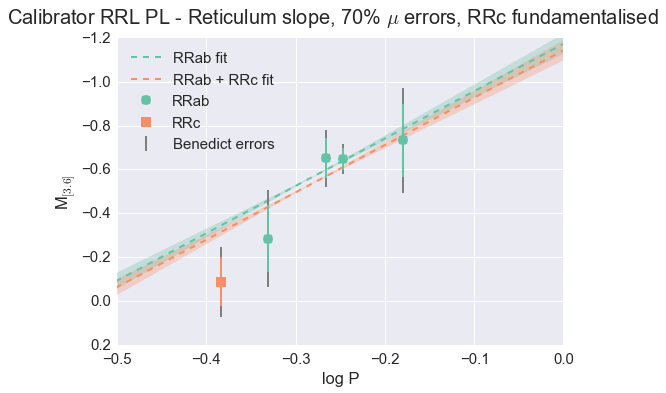

In [301]:
p1 = np.arange(-1,0.1,0.1)

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2", 2)

palette = itertools.cycle(sns.color_palette())

## Error on reticulum slope is 0.08 mag

plt.fill_between(p1, ((slope+(2*0.08))*(p1 + 0.30) + zpab - 2*e_zpab), \
                 ((slope-(2*0.08))*(p1 + 0.30) + zpab + 2*e_zpab), alpha = 0.3, color=next(palette))
plt.fill_between(p1, ((slope+(2*0.08))*(p1 + 0.30) + zp_fund - 2*e_zp_fund), \
                 ((slope-(2*0.08))*(p1+ 0.30) + zp_fund + 2*e_zp_fund), alpha = 0.3, color=next(palette))



plt.plot(p1, slope*(p1 + 0.30) + zpab, ls='--', label="RRab fit", color=next(palette))
plt.plot(p1, slope*(p1 + 0.30) + zp_fund, ls='--', label='RRab + RRc fit', color=next(palette))
plt.errorbar(RRab.log_P, RRab.abs_mag, yerr = RRab.mu_dist_err, color='gray', ls='None', label='Benedict errors', \
            capsize=0.5, zorder=4)
plt.errorbar(RRc.log_P, RRc.abs_mag, yerr = RRc.mu_dist_err, color='gray', ls='None', zorder=4)
plt.errorbar(RRab.log_P, RRab.abs_mag, yerr = RRab.reduced_error, ls='None',zorder=4)
plt.errorbar(RRc.log_P, RRc.abs_mag, yerr = RRc.reduced_error, ls='None',zorder=4)
plt.plot(RRab.log_P, RRab.abs_mag, 'o', label="RRab", ms=10,zorder=4, color=next(palette))
plt.plot(RRc.log_P, RRc.abs_mag, 's', label="RRc", ms=10, zorder=4, color=next(palette))
plt.xlim(-0.5, 0)
plt.ylim(0.2, -1.2)
plt.xlabel('log P')
plt.ylabel('M$_{[3.6]}$')
plt.suptitle('Calibrator RRL PL - Reticulum slope, 70% $\mu$ errors, RRc fundamentalised')
plt.legend(loc='best')


Results of PL fitting:
---------------------
Weighted fits, using reduced uncertainties:

Only RRab fit: zp = {{"%.3f" % zpab}}, error on zp = {{"%.3f" % e_zpab[0]}}, dispersion = {{"%.3f" % sd_no_c}} (only RRab) 
{{"%.3f" % sd_ab}} (including fundamentalised RRc in dispersion calculation)

All stars fit, RRc fundamentalised: zp = {{"%.3f" % zp_fund}}, error on zp = {{"%.3f" % e_zp_fund[0]}}, dispersion = {{"%.3f" % sd_fund}}




Metallicity??
------------

* Metallicity of Reticulum: [Fe/H] = -1.71 $\pm$ 0.1 dex (Dall'Ora et al. 2004, Suntzeff et al. 1992)
* What are the metallicities of these stars?
 - Given in Benedict et al. (2011)

In [172]:
calibrator_data

,ID,log_P,m_36,e_m_36,Amp,type,Av,mu_dist,mu_dist_err,reduced_error,abs_mag,fe_h,e_fe_h
0,RRLyr,-0.24655,6.484,0.014,0.212,ab,0.13,7.14,0.07,0.049,-0.647,-1.41,0.13
1,UVOct,-0.26552,8.200,0.014,0.263,ab,0.28,8.87,0.13,0.091,-0.652,-1.47,0.11
2,XZCyg,-0.33107,8.676,0.016,0.229,ab,0.30,8.98,0.22,0.154,-0.284,-1.44,0.20
3,SUDra,-0.18018,8.616,0.019,0.283,ab,0.03,9.35,0.24,0.168,-0.732,-1.80,0.20
4,RZCep,-0.51052,7.891,0.007,0.116,c,0.78,8.03,0.16,0.112,-0.088,-1.77,0.20


In [173]:
mean_fe_h = calibrator_data.fe_h.mean()
median_fe_h = calibrator_data.fe_h.median()
sigma_fe_h = calibrator_data.fe_h.std()
mean_fe_h, median_fe_h, sigma_fe_h

(-1.578, -1.47, 0.1904468429772466)

Statistics of calibrator stars:
------------------------------
* Mean metallicity: {{"%.2f" % mean_fe_h}} dex
* Median metallicity: {{"%.2f" % median_fe_h}} dex
* Standard deviation of metallicities: {{"%.3f" % sigma_fe_h}} dex

(<matplotlib.legend.Legend at 0x118904490>,
 <matplotlib.text.Text at 0x118637590>)

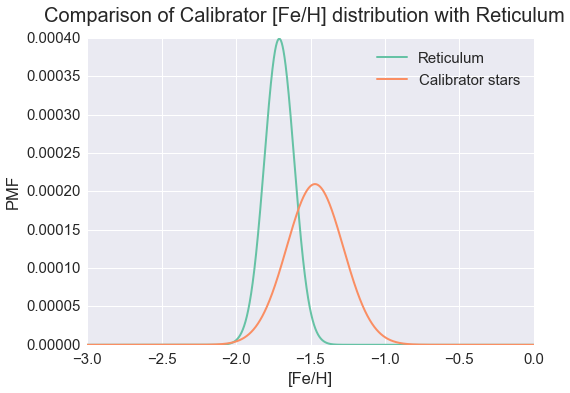

In [174]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2", 2)

errscale = 0.049
photometric = stats.norm(loc=0,scale=errscale)

reticulum_z_dist = stats.norm(loc=-1.71, scale=0.1)
calibrator_z_dist = stats.norm(loc=median_fe_h, scale=sigma_fe_h)
delta = 1e-4
big_grid = np.arange(-3,0,delta)


pmf_retic = reticulum_z_dist.pdf(big_grid)*delta
pmf_calib = calibrator_z_dist.pdf(big_grid)*delta

plt.plot(big_grid,pmf_retic, label='Reticulum')
plt.plot(big_grid,pmf_calib, label='Calibrator stars')
plt.xlabel('[Fe/H]')
plt.ylabel('PMF')

plt.legend(loc='best'), plt.suptitle('Comparison of Calibrator [Fe/H] distribution with Reticulum')

Where does $\omega$ Cen fit into this? M4?
* Assuming Gaussian distributions of metallicities:
 * $\omega$ Cen median [Fe/H] = -1.567 dex, sigma = 0.3 dex (median from Durbin et al, spread is guestimate)
 * M4 median [Fe/H] = -1.10 dex, sigma = 0.10 dex (Neeley et al. 2015, Braga et al. 2015, spread is guestimate)

(<matplotlib.legend.Legend at 0x1163b4850>,
 <matplotlib.text.Text at 0x11a470810>)

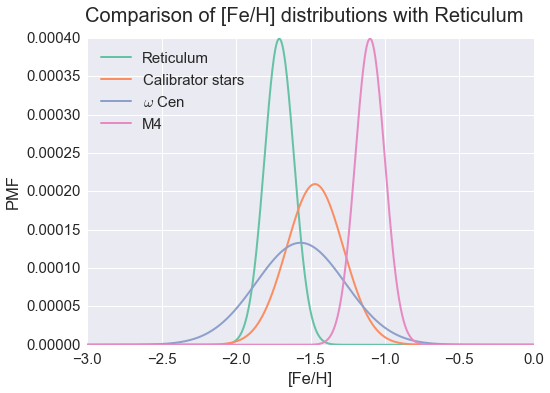

In [175]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2", 4)

errscale = 0.049
photometric = stats.norm(loc=0,scale=errscale)

reticulum_z_dist = stats.norm(loc=-1.71, scale=0.1)
calibrator_z_dist = stats.norm(loc=median_fe_h, scale=sigma_fe_h)
ocen_z_dist = stats.norm(loc=-1.567, scale=0.3)
m4_z_dist = stats.norm(loc=-1.10, scale=0.10)
delta = 1e-4
big_grid = np.arange(-3,0,delta)


pmf_retic = reticulum_z_dist.pdf(big_grid)*delta
pmf_calib = calibrator_z_dist.pdf(big_grid)*delta
pmf_ocen = ocen_z_dist.pdf(big_grid)*delta
pmf_m4 = m4_z_dist.pdf(big_grid)*delta


plt.plot(big_grid,pmf_retic, label='Reticulum')
plt.plot(big_grid,pmf_calib, label='Calibrator stars')
plt.plot(big_grid,pmf_ocen, label='$\omega$ Cen')
plt.plot(big_grid, pmf_m4, label="M4")


plt.plot()
plt.xlabel('[Fe/H]')
plt.ylabel('PMF')

plt.legend(loc='best'), plt.suptitle('Comparison of [Fe/H] distributions with Reticulum')

This is interesting. Reticulum and M4 bracket the two sides of the metallicity distribution of the calibrator stars. Is M4 particularly high in metallicity for a globular cluster?

Comparison of zero-points when using the Reticulum and M4 slopes
------------------------------------------------------------
It looks (by eye) that the calibrator stars and $\omega$ Cen tend towards lower metallicities, and that M4 is at a higher metallicity. Only have samples here, so this might be bollocks. But how does the zero--point change when the M4 slope is used for fitting the calibrators, rather than Reticulum? If metallicity is a factor in the slope, then I would expect the dispersion to increase.

0.130118151011 0.0898222276299 0.116204137657


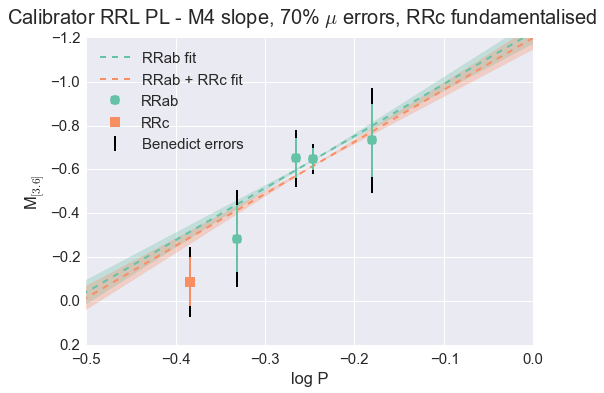

In [302]:
def pl_fit_m4(x, zp):
    return -2.370*(x + 0.26) + zp

popt, pcov = curve_fit(pl_fit_m4, RRab.log_P, RRab.abs_mag, sigma=RRab.reduced_error, absolute_sigma=True)
popt, pcov
slope_m4 = -2.370
zpab_m4 = popt[0]
e_zpab_m4 = pcov[0]
zpab_m4, e_zpab_m4

popt, pcov = curve_fit(pl_fit_m4, fundamentalised.log_P, fundamentalised.abs_mag, sigma=fundamentalised.reduced_error, \
                       absolute_sigma=True)
zp_fund_m4 = popt[0]
e_zp_fund_m4 = pcov[0]
zp_fund_m4, e_zp_fund_m4

## Calculate the dispersion - pretty meaningless for 5 stars though

var_ab_m4 = np.sum((fundamentalised.abs_mag - (slope_m4*(fundamentalised.log_P + 0.26) + zpab_m4))**2) / 5.
sd_ab_m4 = np.sqrt(var_ab_m4)

var_no_c_m4 = np.sum((RRab.abs_mag - (slope_m4*(RRab.log_P + 0.26) + zpab_m4))**2) / 4.
sd_no_c_m4 = np.sqrt(var_no_c_m4)

var_fund_m4 = np.sum((fundamentalised.abs_mag - (slope_m4*(fundamentalised.log_P + 0.26) + zp_fund_m4))**2) / 5.
sd_fund_m4 = np.sqrt(var_fund_m4)

print sd_ab_m4, sd_no_c_m4, sd_fund_m4

p1 = np.arange(-1,0.1,0.1)

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2", 2)

palette = itertools.cycle(sns.color_palette())

plt.fill_between(p1, ((slope_m4+(2*0.106))*(p1 + 0.26) + zpab_m4 - 2*e_zpab_m4), \
                 ((slope_m4-(2*0.106))*(p1 + 0.26) + zpab_m4 + 2*e_zpab_m4), alpha = 0.3, color=next(palette))
plt.fill_between(p1, ((slope_m4+(2*0.106))*(p1 + 0.26) + zp_fund_m4 - 2*e_zp_fund_m4), \
                 ((slope_m4-(2*0.106))*(p1+ 0.26) + zp_fund_m4 + 2*e_zp_fund_m4), alpha = 0.3, color=next(palette))

plt.plot(p1, slope_m4*(p1 + 0.26) + zpab_m4, ls='--', label="RRab fit", color=next(palette))
plt.plot(p1, slope_m4*(p1 + 0.26) + zp_fund_m4, ls='--', label='RRab + RRc fit', color=next(palette))
plt.errorbar(RRab.log_P, RRab.abs_mag, yerr = RRab.mu_dist_err, color='k', ls='None', label='Benedict errors', \
            capsize=0.5, zorder=4)
plt.errorbar(RRc.log_P, RRc.abs_mag, yerr = RRc.mu_dist_err, color='k', ls='None', zorder=4)
plt.errorbar(RRab.log_P, RRab.abs_mag, yerr = RRab.reduced_error, ls='None',zorder=4)
plt.errorbar(RRc.log_P, RRc.abs_mag, yerr = RRc.reduced_error, ls='None',zorder=4)
plt.plot(RRab.log_P, RRab.abs_mag, 'o', label="RRab", ms=10,zorder=4, color=next(palette))
plt.plot(RRc.log_P, RRc.abs_mag, 's', label="RRc", ms=10, zorder=4, color=next(palette))
plt.xlim(-0.5, 0)
plt.ylim(0.2, -1.2)
plt.xlabel('log P')
plt.ylabel('M$_{[3.6]}$')
plt.suptitle('Calibrator RRL PL - M4 slope, 70% $\mu$ errors, RRc fundamentalised')
plt.legend(loc='best')



In [292]:
(slope_m4-(2*0.106)), (slope_m4+(2*0.106))

(-2.544, -2.1199999999999997)

## Results of PL fitting:
---------------------
Weighted fits, using reduced uncertainties:

Only RRab fit: zp = {{"%.3f" % zpab_m4}}, error on zp = {{"%.3f" % e_zpab_m4[0]}}, dispersion = {{"%.3f" % sd_no_c_m4}} (only RRab) 
{{"%.3f" % sd_ab_m4}} (including fundamentalised RRc in dispersion calculation)

All stars fit, RRc fundamentalised: zp = {{"%.3f" % zp_fund_m4}}, error on zp = {{"%.3f" % e_zp_fund_m4[0]}}, dispersion = {{"%.3f" % sd_fund_m4}}

Compare this with numbers from the Reticulum fits:

Only RRab fit: zp = {{"%.3f" % zpab}}, error on zp = {{"%.3f" % e_zpab[0]}}, dispersion = {{"%.3f" % sd_no_c}} (only RRab) 
{{"%.3f" % sd_ab}} (including fundamentalised RRc in dispersion calculation)

All stars fit, RRc fundamentalised: zp = {{"%.3f" % zp_fund}}, error on zp = {{"%.3f" % e_zp_fund[0]}}, dispersion = {{"%.3f" % sd_fund}}

There's not a lot in it. Have a look at the residuals. Do the correlate with eachother? With metallciity?



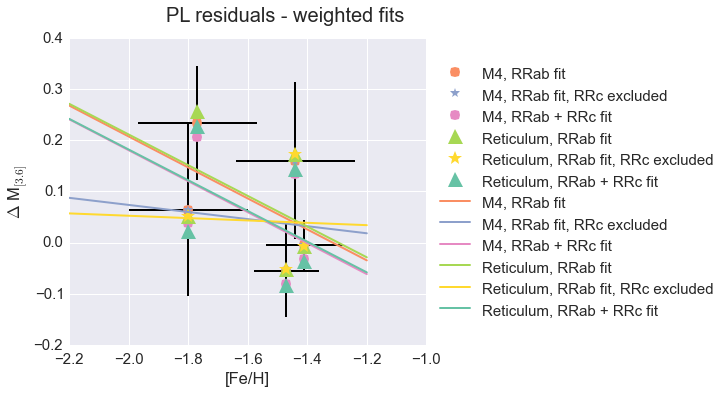

In [217]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2", 6)


retic_resid_ab = fundamentalised.abs_mag - (slope*(fundamentalised.log_P + 0.30) + zpab)
retic_resid_no_c = RRab.abs_mag - (slope*(RRab.log_P + 0.3) + zpab)
retic_resid_fundamentalised = fundamentalised.abs_mag - (slope*(fundamentalised.log_P + 0.3) + zp_fund)
                                                         
m4_resid_ab = fundamentalised.abs_mag - (slope_m4*(fundamentalised.log_P) + zpab_m4)
m4_resid_no_c = RRab.abs_mag - (slope_m4*(RRab.log_P) + zpab_m4)
m4_resid_fundamentalised = fundamentalised.abs_mag - (slope_m4*(fundamentalised.log_P) + zp_fund_m4)
  
fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(fe_h, m4_resid_ab, yerr=fundamentalised.reduced_error, xerr=fundamentalised.e_fe_h, ls='None', c='k')
ax.plot(fe_h, m4_resid_ab, 'o', ms=10, ls='None', label='M4, RRab fit')
ax.plot(RRab.fe_h, m4_resid_no_c, '*', ms=10, ls='None', label='M4, RRab fit, RRc excluded')
ax.plot(fe_h, m4_resid_fundamentalised, 'o', ms=10, ls='None', label='M4, RRab + RRc fit')


ax.plot(fe_h, retic_resid_ab, '^', ms=15, ls='None', label='Reticulum, RRab fit')
ax.plot(RRab.fe_h, retic_resid_no_c, '*', ms=15, ls='None', label='Reticulum, RRab fit, RRc excluded')
ax.plot(fe_h, retic_resid_fundamentalised, '^', ms=15, ls='None', label='Reticulum, RRab + RRc fit')


## Can you measure a metallicity effect from these stars?

def metal_effect(x, slope, zp):
    return slope*x + zp

m4_rrab_params, m4_rrab_errs = curve_fit(metal_effect, fundamentalised.fe_h, m4_resid_ab)
m4_no_c_params, m4_no_c_errs = curve_fit(metal_effect, RRab.fe_h, m4_resid_no_c)
m4_fund_params, m4_fund_errs = curve_fit(metal_effect, fundamentalised.fe_h, m4_resid_fundamentalised)

retic_rrab_params, retic_rrab_errs = curve_fit(metal_effect, fundamentalised.fe_h, retic_resid_ab)
retic_no_c_params, retic_no_c_errs = curve_fit(metal_effect, RRab.fe_h, retic_resid_no_c)
retic_fund_params, retic_fund_errs = curve_fit(metal_effect, fundamentalised.fe_h, retic_resid_fundamentalised)

#plt.xlim(-2.1, -1.20)
#plt.ylim(-0.2, 0.4)

fe_h_l = np.arange(-2.2, -1.1, 0.1)

ax.plot(fe_h_l, (m4_rrab_params[0]*fe_h_l) +  m4_rrab_params[1], ls='-', label='M4, RRab fit')
ax.plot(fe_h_l, m4_no_c_params[0]*fe_h_l +  m4_no_c_params[1], ls='-', label='M4, RRab fit, RRc excluded')
ax.plot(fe_h_l, m4_fund_params[0]*fe_h_l +  m4_fund_params[1], ls='-', label='M4, RRab + RRc fit')
ax.plot(fe_h_l, retic_rrab_params[0]*fe_h_l +  retic_rrab_params[1], ls='-', label='Reticulum, RRab fit')
ax.plot(fe_h_l, retic_no_c_params[0]*fe_h_l +  retic_no_c_params[1], ls='-', label='Reticulum, RRab fit, RRc excluded')
ax.plot(fe_h_l, retic_fund_params[0]*fe_h_l +  retic_fund_params[1], ls='-', label='Reticulum, RRab + RRc fit')

plt.xlabel('[Fe/H]')
plt.ylabel('$\Delta$ M$_{[3.6]}$')
plt.suptitle('PL residuals - weighted fits')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



                                                         

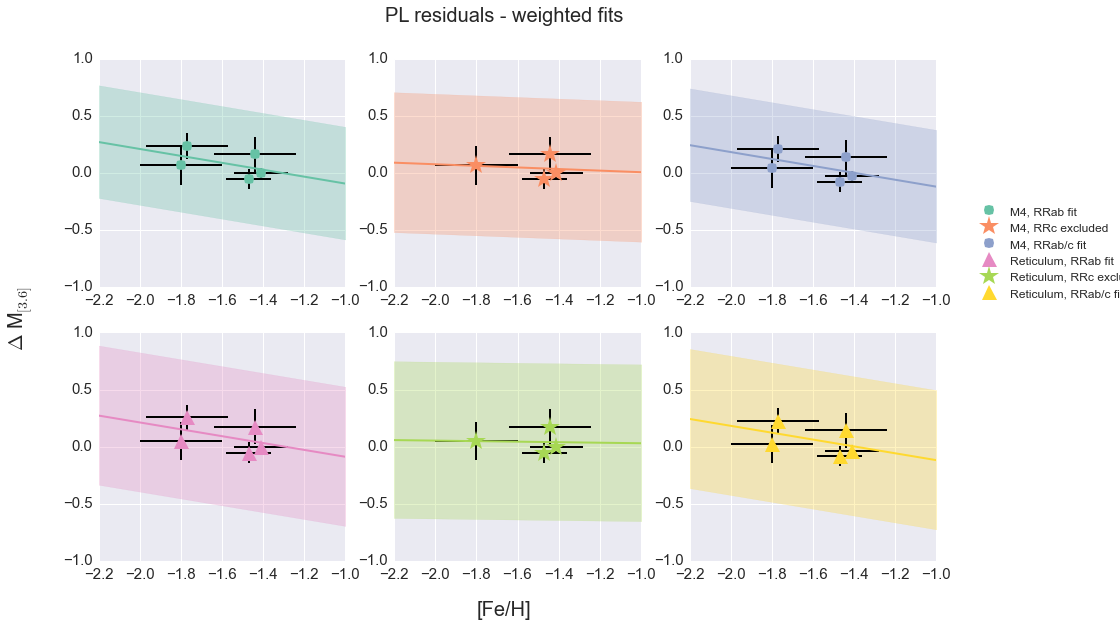

In [303]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2", 6)

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharex=ax1, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharex=ax1, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharex=ax1, sharey=ax1)


palette = itertools.cycle(sns.color_palette())

ax1.errorbar(fe_h, m4_resid_ab, yerr=fundamentalised.reduced_error, xerr=fundamentalised.e_fe_h, ls='None', c='k')
ax1.plot(fe_h, m4_resid_ab, 'o', ms=10, ls='None', label='M4, RRab fit', color=next(palette))
plt.xlim(-2.2, -1)
plt.ylim(-1., 1.)
ax2.errorbar(RRab.fe_h, m4_resid_no_c, yerr=RRab.reduced_error, xerr=RRab.e_fe_h, ls='None', c='k')
ax2.plot(RRab.fe_h, m4_resid_no_c, '*', ms=20, ls='None', label='M4, RRc excluded', color=next(palette))

ax3.errorbar(fe_h, m4_resid_fundamentalised, yerr=fundamentalised.reduced_error, xerr=fundamentalised.e_fe_h, ls='None', c='k')
ax3.plot(fe_h, m4_resid_fundamentalised, 'o', ms=10, ls='None', label='M4, RRab/c fit', color=next(palette))

ax4.errorbar(fe_h, retic_resid_ab, yerr=fundamentalised.reduced_error, xerr=fundamentalised.e_fe_h, ls='None', c='k')
ax4.plot(fe_h, retic_resid_ab, '^', ms=15, ls='None', label='Reticulum, RRab fit', color=next(palette))

ax5.errorbar(RRab.fe_h, retic_resid_no_c, yerr=RRab.reduced_error, xerr=RRab.e_fe_h, ls='None', c='k')
ax5.plot(RRab.fe_h, retic_resid_no_c, '*', ms=20, ls='None', label='Reticulum, RRc excluded', color=next(palette))

ax6.errorbar(fe_h, retic_resid_fundamentalised, yerr=fundamentalised.reduced_error, xerr=fundamentalised.e_fe_h, ls='None', c='k')
ax6.plot(fe_h, retic_resid_fundamentalised, '^', ms=15, ls='None', label='Reticulum, RRab/c fit', color=next(palette))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()
h4, l4 = ax4.get_legend_handles_labels()
h5, l5 = ax5.get_legend_handles_labels()
h6, l6 = ax6.get_legend_handles_labels()



## Can you measure a metallicity effect from these stars?

def metal_effect(x, slope, zp):
    return slope*x + zp

m4_rrab_params, m4_rrab_errs = curve_fit(metal_effect, fundamentalised.fe_h, m4_resid_ab)
m4_no_c_params, m4_no_c_errs = curve_fit(metal_effect, RRab.fe_h, m4_resid_no_c)
m4_fund_params, m4_fund_errs = curve_fit(metal_effect, fundamentalised.fe_h, m4_resid_fundamentalised)

retic_rrab_params, retic_rrab_errs = curve_fit(metal_effect, fundamentalised.fe_h, retic_resid_ab)
retic_no_c_params, retic_no_c_errs = curve_fit(metal_effect, RRab.fe_h, retic_resid_no_c)
retic_fund_params, retic_fund_errs = curve_fit(metal_effect, fundamentalised.fe_h, retic_resid_fundamentalised)


fe_h_l = np.arange(-3, -0, 0.1)



ax1.fill_between(fe_h_l, (m4_rrab_params[0]*fe_h_l) +  m4_rrab_params[1]-(2*m4_rrab_errs[1][1]), \
                 (m4_rrab_params[0]*fe_h_l) +  m4_rrab_params[1]+(2*m4_rrab_errs[1][1]), alpha = 0.3, \
                 color=next(palette))

ax2.fill_between(fe_h_l, (m4_no_c_params[0]*fe_h_l) +  m4_no_c_params[1]-(2*m4_no_c_errs[1][1]), \
                 (m4_no_c_params[0]*fe_h_l) +  m4_no_c_params[1]+(2*m4_no_c_errs[1][1]), alpha = 0.3, \
                 color=next(palette))

ax3.fill_between(fe_h_l, (m4_fund_params[0]*fe_h_l) +  m4_fund_params[1]-(2*m4_fund_errs[1][1]), \
                 (m4_fund_params[0]*fe_h_l) +  m4_fund_params[1]+(2*m4_fund_errs[1][1]), alpha = 0.3, \
                 color=next(palette))
ax4.fill_between(fe_h_l, (retic_rrab_params[0]*fe_h_l) +  retic_rrab_params[1]-(2*retic_rrab_errs[1][1]), \
                 (retic_rrab_params[0]*fe_h_l) +  retic_rrab_params[1]+(2*retic_rrab_errs[1][1]), alpha = 0.3, \
                 color=next(palette))

ax5.fill_between(fe_h_l, (retic_no_c_params[0]*fe_h_l) +  retic_no_c_params[1]-(2*retic_no_c_errs[1][1]), \
                 (retic_no_c_params[0]*fe_h_l) +  retic_no_c_params[1]+(2*retic_no_c_errs[1][1]), alpha = 0.3, \
                 color=next(palette))

ax6.fill_between(fe_h_l, (retic_fund_params[0]*fe_h_l) +  retic_fund_params[1]-(2*retic_fund_errs[1][1]), \
                 (retic_fund_params[0]*fe_h_l) +  retic_fund_params[1]+(2*retic_fund_errs[1][1]), alpha = 0.3, \
                 color=next(palette))



ax1.plot(fe_h_l, (m4_rrab_params[0]*fe_h_l) +  m4_rrab_params[1], ls='-', \
         label='M4, RRab fit', color=next(palette))
ax2.plot(fe_h_l, m4_no_c_params[0]*fe_h_l +  m4_no_c_params[1], ls='-', \
         label='M4, RRc excluded', color=next(palette))
ax3.plot(fe_h_l, m4_fund_params[0]*fe_h_l +  m4_fund_params[1], ls='-', \
         label='M4, RRab/c fit', color=next(palette))
ax4.plot(fe_h_l, retic_rrab_params[0]*fe_h_l +  retic_rrab_params[1], ls='-', \
         label='Reticulum, RRab fit', color=next(palette))
ax5.plot(fe_h_l, retic_no_c_params[0]*fe_h_l +  retic_no_c_params[1], ls='-', \
         label='Reticulum, RRc excluded', color=next(palette))
ax6.plot(fe_h_l, retic_fund_params[0]*fe_h_l +  retic_fund_params[1], ls='-', \
         label='Reticulum, RRab/c fit', color=next(palette))

#plt.xlabel('[Fe/H]')
#plt.ylabel('$\Delta$ M$_{[3.6]}$')
plt.suptitle('PL residuals - weighted fits')

handles = np.concatenate((h1,h2, h3, h4, h5, h6))
labels = np.concatenate((l1, l2, l3, l4, l5, l6))

#ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.figlegend(handles, labels, numpoints=1, fontsize=12, \
              bbox_to_anchor=(0.9, 0.5), loc='lower left', borderaxespad=0.)

fig.text(0.5, 0.04, '[Fe/H]', ha='center')
fig.text(0.04, 0.5, '$\Delta$ M$_{[3.6]}$', va='center', rotation='vertical')




Comparison of the Reticulum and M4 residuals:
------------------------------------------

Most robust fit in both cases is the RRab only fit. Compare how the residuls behave in these fits

(-0.2, 0.4)

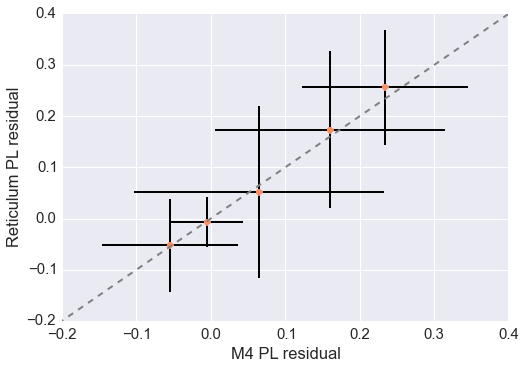

In [318]:
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_palette("Set2")

xra = np.arange(-0.5, 0.5, 0.1)

plt.errorbar(m4_resid_ab, retic_resid_ab, yerr=fundamentalised.reduced_error, xerr=fundamentalised.reduced_error, ls='None', c='k')
plt.plot(m4_resid_ab,retic_resid_ab, 'o', ls='None')
plt.plot(xra , xra, ls='--', c='gray')
plt.xlabel("M4 PL residual")
plt.ylabel("Reticulum PL residual")
plt.xlim(-0.2, 0.4)
plt.ylim(-0.2, 0.4)

I have no idea what this is telling me.

They aren't evenly distributed around zero. Is this because of the weighting? The period distribution? What *is* the period distribution?

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([-0.38352 , -0.363186, -0.342852, -0.322518, -0.302184, -0.28185 ,
        -0.261516, -0.241182, -0.220848, -0.200514, -0.18018 ]),
 <a list of 10 Patch objects>)

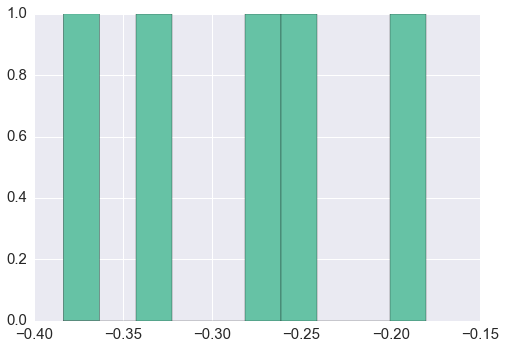

In [320]:
plt.hist(fundamentalised.log_P)

Well, that's fucking useless. How does it compare to M4? Are we sampling a similar period range? What about Reticulum and $\omega$ Cen?